# 1. Xử lý dữ liệu

In [1]:
#import needed libraries
!pip install transformers
!pip install py_vncorenlp
import requests
import re
from bs4 import BeautifulSoup
import py_vncorenlp
import torch
from transformers import AutoModel, AutoTokenizer
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 93.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 24.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 14.1 MB/s eta 0:00:00
  Created wheel for py_vncorenlp: filename=py_vncorenlp-0.1.4-py3-none-any.whl size=4306 sha256=9f0c6ca4a6a2a467420da5fadb91f300fd4ad29b5a9ec2e9ecaa834b49bde5a3
  Stored in directory: /root/.cache/pip/wheels/d5/d9/bf/62632cdb007c702a0664091e92a0bb1f18a2fcecbe962d9827
Successfully built py_vncorenlp


In [3]:
# link to crawl data
u1 = "https://laodong.vn/xa-hoi?page="
u2 = "https://laodong.vn/the-thao?page="
u3 = "https://laodong.vn/van-hoa-giai-tri?page="
u4 = "https://laodong.vn/kinh-doanh?page="
u5 = "https://laodong.vn/the-gioi?page="
u6 = "https://laodong.vn/thoi-su?page="

In [4]:
#get needed information of a website
def find_all_articles(max_sl, web_link):
  data_link = []
  for i in range(1, 40):
    url = web_link + str(i)
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    data_link += soup.find_all("a", class_="link-title")
  return data_link

In [5]:
data_link = list()
data_link += find_all_articles(50, u1)
data_link += find_all_articles(50, u2)
data_link += find_all_articles(50, u3)
data_link += find_all_articles(50, u4)
data_link += find_all_articles(50, u5)
data_link += find_all_articles(50, u6)
data_link = list(set(data_link))

In [6]:
data_link[0]

<a class="link-title" href="https://laodong.vn/xa-hoi/quan-chi-dao-phuong-thuc-hien-cham-vu-8-tan-ca-koi-tha-o-ho-dam-dong-1261256.ldo"><h2 class="title prefix-icon">Quận chỉ đạo, phường thực hiện chậm vụ 8 tấn cá koi thả ở hồ Đầm Đông</h2></a>

In [7]:
for link in data_link:
  print(link.text)

Quận chỉ đạo, phường thực hiện chậm vụ 8 tấn cá koi thả ở hồ Đầm Đông
Cục phó Hải quan Hà Tĩnh làm Cục trưởng Hải quan Quảng Bình
Tỉ phú giàu nhất châu Âu bị điều tra về mối quan hệ với doanh nhân người Nga
Đất rừng phương Nam và Nhà bà Nữ tranh giải Bông Sen Vàng
Tìm về cổng địa ngục khai sinh ra Halloween
Alcaraz bị loại ngay vòng 1 Paris Masters
Hàng nghìn phụ nữ Tây Đô mặc áo bà ba, áo dài diễu hành bên bờ sông Hậu
Chi Pu đích thân phục vụ khách ghé quán phở vừa khai trương ở Trung Quốc
Công bố hướng cao tốc Nha Trang - Đà Lạt với vốn khoảng 34.000 tỉ đồng
Lisa Blackpink vượt Jennie, Suga BTS để đạt kỉ lục mới trong sự nghiệp solo
Hồ sơ kỳ án: Con tàu bất hạnh và sự mất tích của thuỷ thủ đoàn
Các ứng dụng công nghệ sáng tạo được phát triển từ Đề án 06
6 giờ phẫu thuật cứu bé gái bị biến dạng vùng mặt do tai nạn giao thông
Ông Lý Thượng Phúc không còn là Bộ trưởng Quốc phòng Trung Quốc
Cuộc sống ở tuổi U80 của NSND Lệ Thủy và mối quan hệ với NSND Minh Vương
Nghịch cảnh của Erik ten 

In [8]:
print(len(data_link))

3273


# 2. PhoBERT

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Automatically download VnCoreNLP components from the original repository
# and save them in some local machine folder
py_vncorenlp.download_model(save_dir = "/content/drive/MyDrive/py_vncorenlp")

rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir='/content/drive/MyDrive/py_vncorenlp')

VnCoreNLP model folder /content/drive/MyDrive/py_vncorenlp already exists! Please load VnCoreNLP from this folder!


In [11]:
#word-semented data
data_ws = list()
for col in data_link:
  data_ws.append(str(rdrsegmenter.word_segment(col.text)))
data_ws[0]

"['Quận chỉ_đạo , phường thực_hiện chậm vụ 8 tấn cá koi thả ở hồ Đầm Đông']"

In [12]:
phobert = AutoModel.from_pretrained("vinai/phobert-base-v2")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


For a given token, its input representation is constructed by summing the corresponding token embedding, segment embedding, and position embedding. This input representation is called the initial embedding output which can be found at index 0 of the tuple hidden_states. This figure explains how the embeddings are calculated.

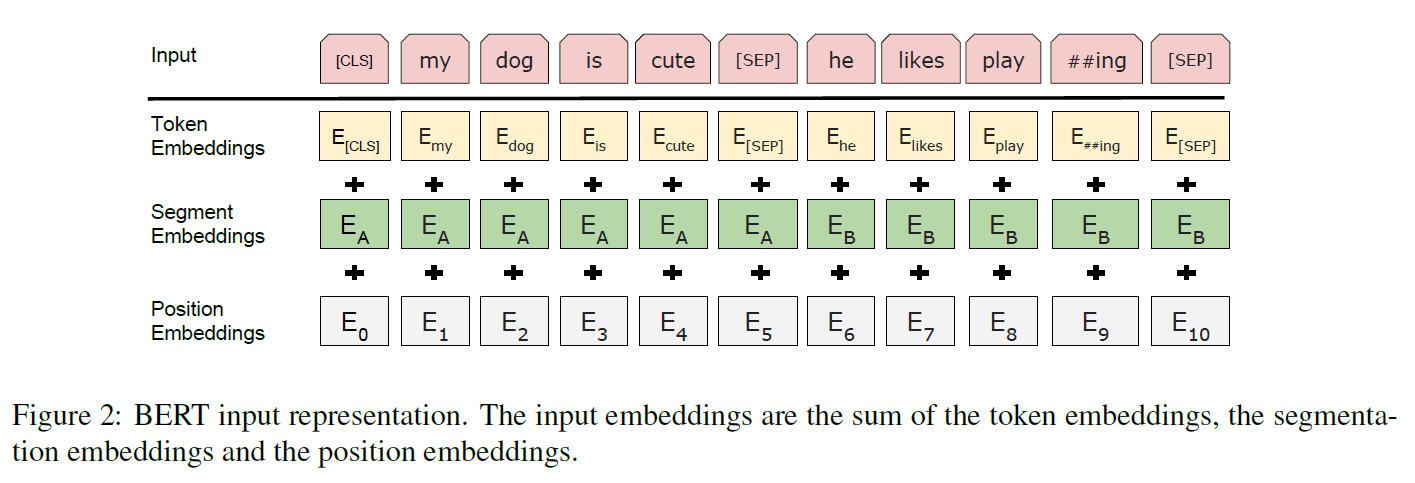

In [18]:
input_ids = torch.tensor([tokenizer.encode(data_ws[0])])

with torch.no_grad():
    data = phobert(input_ids).pooler_output.numpy()
print(data)

[[ 1.53892185e-03  2.51618475e-02  7.48285130e-02  1.17847517e-01
   1.57054383e-02 -1.08029678e-01  3.05818856e-01 -9.04602557e-02
  -3.51920016e-02 -5.72256856e-02 -9.53111500e-02  2.26430669e-01
   9.53456163e-02 -1.09678775e-01 -1.69750258e-01 -8.93606320e-02
  -3.07654729e-03  6.90051988e-02 -4.68031988e-02  1.66836470e-01
   5.05052619e-02  2.19582230e-01  1.01591982e-01  1.41407996e-01
  -2.33393893e-01  1.47831768e-01 -1.53505310e-01  8.95877089e-03
  -1.08404949e-01 -3.57650034e-02 -1.82432935e-01 -1.83316991e-01
  -1.07000005e-02  1.00821376e-01  4.70942318e-01 -6.15809895e-02
   1.15147546e-01 -8.13850537e-02  2.58373320e-02  1.08334042e-01
   1.07824706e-01 -1.75174654e-01  3.59918140e-02  1.26823112e-01
   3.68422084e-02 -8.64136964e-02 -3.99158180e-01 -8.75982195e-02
  -1.23591080e-01 -1.39824197e-01  1.71743765e-01 -2.74296524e-03
   3.42968106e-02 -9.52757224e-02  3.00472677e-01 -2.09365159e-01
  -8.80573243e-02  7.24397004e-02  8.52504745e-02 -5.23100011e-02
   5.02703

In [19]:
for i in range(1, len(data_ws)):
  val_ids = torch.tensor([tokenizer.encode(data_ws[i])])
  with torch.no_grad():
    data = np.vstack([data, phobert(val_ids).pooler_output.numpy().flatten()])

In [20]:
print(data)

[[ 0.00153892  0.02516185  0.07482851 ... -0.03323319 -0.08701701
  -0.14499077]
 [-0.08606753  0.04811432  0.09511551 ... -0.10329825 -0.15348232
  -0.09861154]
 [-0.11694836  0.03830498  0.02237222 ... -0.01043554  0.0808494
  -0.23201561]
 ...
 [-0.20124689  0.0742064  -0.01854614 ... -0.10586767 -0.11625677
  -0.18692799]
 [-0.05970228 -0.02500406  0.14508007 ... -0.08739318 -0.05356476
  -0.20044424]
 [-0.22314273 -0.01612957  0.04842049 ... -0.09084931 -0.02813179
  -0.20043047]]


In [21]:
data.shape

(3273, 768)

# 3. Truy vấn user-text

In [85]:
#nhận query lấy được từ bàn phím
query = input()

Messi


In [86]:
#Word-segmented cho query-text
query = 'Các tiêu đề liên quan đến chủ đề ' + query
query = rdrsegmenter.word_segment(query)
print(query)
#encoded the query
cv_query = torch.tensor([tokenizer.encode(str(query))])
with torch.no_grad():
  cv_query = phobert(cv_query).pooler_output.numpy().flatten()
print(cv_query)

['Các tiêu_đề liên_quan đến chủ_đề Messi']
[ 3.84906074e-03 -1.03322275e-01  1.59503855e-02  2.55231500e-01
  1.84588194e-01 -1.50314987e-01  1.39586195e-01 -1.09445222e-01
 -1.64526254e-01 -1.80575140e-02 -6.35179952e-02  3.42508778e-04
  1.92737073e-01 -2.00370878e-01 -1.19209491e-01 -2.06723601e-01
 -1.65818743e-02 -1.27169311e-01 -9.32697579e-02 -1.16673054e-03
 -1.13825493e-01  2.59488612e-01  6.53944910e-02  4.80547212e-02
 -1.37013897e-01  2.23007351e-01 -1.67873561e-01  8.16971529e-03
  6.22005798e-02 -8.22875500e-02 -1.78438306e-01 -1.23549342e-01
 -3.68653908e-02  2.21599758e-01  3.22139829e-01  5.92361614e-02
  2.66581625e-02 -9.46648046e-02 -8.80458131e-02  1.34126648e-01
 -6.53562471e-02 -1.20049015e-01  1.64064080e-01 -4.60607745e-02
 -1.59996394e-02 -2.18403071e-01 -4.37460840e-01 -9.63323563e-03
 -1.30749673e-01 -1.36514008e-01  4.95215245e-02 -8.14431906e-02
 -1.10554807e-02 -1.10716268e-01  8.87927115e-02 -1.64776489e-01
 -7.30362162e-02 -3.12967859e-02 -9.76277888e-0

# Cosine similarity

In [87]:
#Calculate cos of two vectors (i-th data and query encoded vector :>)
cos_similarity = []
for i in range(data.shape[0]):
  cos_similarity.append(data[i,:].dot(cv_query) / (np.linalg.norm(data[i,:]) * np.linalg.norm(cv_query)))
print(cos_similarity)

[0.77241457, 0.77562267, 0.77396154, 0.7486213, 0.7708211, 0.8063639, 0.74046624, 0.766343, 0.78798395, 0.76745373, 0.7854718, 0.8214225, 0.7616607, 0.7436897, 0.7439121, 0.74911875, 0.69447637, 0.80950344, 0.81194806, 0.73442644, 0.7464692, 0.7445038, 0.74306214, 0.6421468, 0.7589711, 0.66147053, 0.7556938, 0.73367095, 0.73418987, 0.7693034, 0.77206045, 0.83743966, 0.77965105, 0.7648785, 0.7801854, 0.8145733, 0.7883006, 0.7917403, 0.7671215, 0.7597131, 0.80687755, 0.798098, 0.746679, 0.8089203, 0.80898666, 0.722266, 0.78942806, 0.7870715, 0.7968462, 0.79321975, 0.8048964, 0.72966087, 0.81426543, 0.76155233, 0.7697883, 0.7582699, 0.7790043, 0.726466, 0.7669247, 0.7970505, 0.7893261, 0.8476949, 0.8100082, 0.75559855, 0.69248265, 0.75581896, 0.7879881, 0.77472526, 0.6681688, 0.8106695, 0.7305199, 0.81364775, 0.7407645, 0.7447889, 0.7633824, 0.7345769, 0.8358809, 0.7522221, 0.78629446, 0.74928045, 0.7740294, 0.81799084, 0.7426579, 0.8152589, 0.77783567, 0.778357, 0.76567787, 0.76976854, 0

In [88]:
#Rank k vectors from data that have highest cosine value
#Step 1: Sort cosine values
sorted_ids_data = np.argsort(np.array(cos_similarity))
#Step 2: Reverse the order of the sorted_ids array
sorted_ids = sorted_ids_data[::-1]
#Step 3: Get k indices
k = 10
k_idx = sorted_ids[0: k]
print(k_idx)

[ 611 2564 1311 2116   61  554  398  144 2482  855]


# Print k-th answers

In [89]:
cnt = 1
for i in k_idx:
  print('rank '+ str(cnt) + ' is the article name: ' + data_link[int(i)].text + ' , cosine: ' + str(cos_similarity[i]))
  cnt += 1

rank 1 is the article name: Những bài học đã phải trả bằng rất nhiều tiền trong đầu tư cho các lĩnh vực văn hóa , cosine: 0.8534017
rank 2 is the article name: Hàng loạt tài khoản Facebook giả mạo HOSE , cosine: 0.8528281
rank 3 is the article name: Khởi tranh giải golf từ thiện vì trẻ em Việt Nam , cosine: 0.84862155
rank 4 is the article name: Trắc nghiệm: Bạn biết gì về bộ phim có doanh thu cao nhất mọi thời đại? , cosine: 0.8477614
rank 5 is the article name: Quả bóng vàng và những dấu hỏi , cosine: 0.8476949
rank 6 is the article name: Indonesia cấm bán hàng trên mạng xã hội , cosine: 0.84687215
rank 7 is the article name: Người dân Trung Quốc phải sơ tán do bão Koinu , cosine: 0.84678537
rank 8 is the article name: Loạt nguyên nhân khiến lũ lụt gây hậu quả thảm khốc ở Libya , cosine: 0.84381163
rank 9 is the article name: Hé lộ những vùng giàu mạnh nhất của Nga , cosine: 0.84356093
rank 10 is the article name: Tìm hướng đi phù hợp cho thể thao Việt Nam , cosine: 0.84319913
